# golive learn

First things first: Towards learning Python for Data Science this *recommendation*:

> ***locate*** and ***work through*** the 
[Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/)
by Jake VanderPlas, available free online. 


The **golive** notebooks cover access to and analysis of large geospatial datasets using the
Python stack: Python 3, numpy, matplotlib, pandas, xarray, dask, and ultimately the pangeo 
framework; with digressions to widgets and ipyleaflet maps and so on. 


Data and a scientific problem:


> * The *golive* dataset is land ice velocity fields from 2013 through present
>   * For our purposes: mesoscale valley glacier systems
> * What sort of speed variability patterns are discernible in the **golive** data?


This notebook `golive_learn.ipynb` works through the mechanics of using the Python tools with
the *golive* data as the subject matter. 

Some prefatory notes: 

- `xarray` is abbreviated `xr`
  - `xr.DataArray` and `xr.Dataset` are respectively the two principle data object constructs
  - NetCDF data files translate into `xr.Dataset` objects by means of an `open()` call 


#### Contents

* S0. The utility code cell
* S1. Types and data manipulation packages 
* S2. IPython and Jupyter notebooks
* S3. Exploratory session on golive DataSets

## S0. utility code cell

The *golive* notebooks make use of a common set of package imports and utility methods. 
The imports are copied by rote to each notebook and the methods are imported from 
`golive_utility.py`. The line-magic call `%matplotlib inline` and the two `pip install` calls 
are also rote. The `gdal` and `pygeotools` imports seem to be problematical (flag May 3 2019).

In a perfect world this is cleaned up. In this world the corresponding utility code cell block 
is painstakingly re-copied from one notebook to the others in the `golive` collection to make 
sure these notebooks are all working from the same resource playbook. 

In [1]:
%matplotlib inline

!pip install utm
!pip install pygeotools

import timeit
from datetime import timedelta, datetime
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import dask
import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from random import randint as ri

from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import sys
import os
import utm

# from osgeo import gdal 
# from pygeotools.lib import iolib,timelib

import golive_utility as g

## S1. Types and data manipulation packages 


As noted above the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/)
is an excellent preparatory resource. It is freely available online where chapters 1 and 2 would be (ideally)
mastered first before proceeding here. 


Python has four native data types: float, int, bool and string. A string behaves something like a list but it is 
immutable whereas a list has the `.append()` method; it can be modified during execution. 


The *Numerical Python* library `numpy` (abbreviated `np`) introduces arrays. 
In fact these arrays can be multi-dimensional and of type `ndarray` meaning *n-dimensional array*. 


Then we need to touch on `pandas` before jumping to `xarray`. flag this section is incomplete May 3 2019.


### Data acquisition and storage


The `golive` data files are NetCDF files resident on an ftp server. Unfortunately (against principles) we need
to copy them to this local Jupyter environment. For this we use the `wget` command. The files are place in:

```
<home>/data/golive
<home>/data/golive_big
``` 

One single file is typically 15MB. It covers a single time window spanned by two source LANDSAT-8 images.
This time window is one of: 16, 32, 48, 64, 80, or 96 days. These files are generated automatically and 
feature good data and plenty of no-data values from obscurement (clouds). LANDSAT frames are designated 
by path and row coordinates and each covers approximately 80 x 80 kilometers. Path and row coordinates 
are intrinsic to satellite tracks, not earth coordinates. The good news is that the data are organized
by UTM coordinates, i.e. earth coordinates. The slightly bad news is that the UTM zone is a bit 
tricky to establish (which one?) and without figuring this out we can get frames from different
path-row pairs that appear to have the same coordinates (when in fact they are in different UTM zones).


## S2. IPython and Jupyter notebooks


### IPython


### Jupyter shortcuts


[This blog post](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/) gives useful shortcuts
for operating Jupyter notebooks including the idea of an ESC escape mode:

- **a** adds a cell above
- **b** adds a cell below
- **m** changes a selected cell to markdown
- **y** changes a cell to code
- **d twice** deletes the current cell

- **Ctrl Shift minus-sign** will split the current cell into two from where your cursor is
- **f** Find and replace on your code but not the outputs
- **o** Toggle cell output: Frequently used here!


- **Shift + J** or **Shift + down** does multi-select downwards
- **Shift + K** or **Shift + up** does upwards
- **Shift + M** to merge

- **Shift + Tab** will show the Docstring (documentation) for an object or method where your cursor is. If you have just typed the object into a cell you can keep pressing **Shift + Tab** to cycle through the modes of documentation

In [1]:
print('''
Here is a very useful tip for accessing object methods and sub-methods...

- Type the name of the object with trailing period
- place the cursor after this period
- hit Shift + Tab multiple times

this will display docstring variants

''')


Here is a very useful tip for accessing object methods and sub-methods...

- Type the name of the object with trailing period
- place the cursor after this period
- hit Shift + Tab multiple times

this will display docstring variants




## S3. Exploratory session on golive DataSets


This section 'deconstructs' a small set of NetCDF files first by pulling them into a list of `xarray Datasets`. 
This goes against principle! Better is to concatenate them into a *single* such `Dataset`.  This is 
done properly further below. Here we use list m\[\] as a list of six `xarray DataSets`. 



In [ ]:
golive_d = g.SetDataDirectory('golive')              # small set of six NetCDF files
golive_big_d = g.SetDataDirectory('golive_big')      # big set of > 1000 NetCDF files

In [34]:
# This cell is a preview of 'what's inside the data files
# Set the boolean to True to actually run the cell
# 
# The idea here is that these data files are not a priori sortable by time using xarray
#   so we use the time built into the data file as an attribute to generate a coordinate/dimension of time.
#   This is then used to consolidate multiple files into a single xarray Dataset using .open_mfdataset()

if False:
    datafile = 'L8_063_018_016_2014_050_2014_066_v1.1.nc'         # choosing an arbitrary source data file
    ds = xr.open_dataset(golive_d + datafile)                     #   ...open a single file as a Dataset 'ds'
    print(type(ds['image_pair_times'].attrs['mid_date']), '\n')   # print the type of this date attribute
    print(ds['image_pair_times'].attrs['mid_date'], '\n')         #   ...and print this attribute's value
    s = ds['image_pair_times'].attrs['mid_date']          
    ts = pd.Timestamp(s)                                          # convert this string to a pandas Timestamp
    print('pandas timestamp:', ts, '\n')                          #   and print it
    
    print(ds, '\n\n\n')                                           # Notice 'ds' has no time coordinate/dimension
    ds['time'] = xr.Variable('time', [ts])                        #   ...so add one...
    print(ds)                                                     #   ...and now it is present

In [21]:
%%time

# The %%time cell magic timer must be the first line of the cell with no trailing whitespace

# data_location = golive_big_d         (uncomment to look at the large data pool)
data_location = golive_d
do_Dataset_accumulate = True if data_location == golive_d else False

fl = g.lsal(data_location)               # create file list fl from the files in the (small) golive data directory

fnc, fpng, ftif, dur, year, doy, m = [], [], [], [], [], [], []

# Item [7] in a given line is the file name. If it starts with L8 and ends with .nc, .png, or .tif then it is source data

for x in fl:
    sp = x.strip().split()    # file description line; filename is [8]
    if len(sp) == 9:
        if sp[8][0:3] == 'L8_':
            if sp[8][-3:] == '.nc':
                fnc.append(golive_d + sp[8])
                dur.append(int(fnc[-1].split('_')[3]))
                year.append(int(fnc[-1].split('_')[4]))
                doy.append(int(fnc[-1].split('_')[5]))
                if do_Dataset_accumulate: m.append(xr.open_mfdataset(golive_d + sp[8]))
            elif sp[8][-4:] == '.png': fpng.append(golive_d + sp[8])
            elif sp[8][-4:] == '.tif': ftif.append(golive_d + sp[8])
            
print('m-list includes', len(m), 'datasets from', len(fnc), 'source data files\n')

m-list includes 6 datasets from 6 source data files

CPU times: user 105 ms, sys: 6.45 ms, total: 111 ms
Wall time: 159 ms


In [19]:
print(m[0]['vx_masked'])
print('\n')
# Identical: print(m[0].vx_masked)

print(m[0].vx_masked.x)
print('\n')
print(m[0].history)
print('\n')
print(m[0].processing_log)
print('\n')
print(m[0].processing_log.attrs['standard_name'])
print('\n')

<xarray.DataArray 'vx_masked' (y: 828, x: 819)>
dask.array<shape=(828, 819), dtype=float32, chunksize=(828, 819)>
Coordinates:
  * x        (x) float64 3.331e+05 3.334e+05 3.337e+05 ... 5.782e+05 5.785e+05
  * y        (y) float64 6.786e+06 6.785e+06 6.785e+06 ... 6.538e+06 6.537e+06
Attributes:
    grid_mapping:   transverse_mercator
    standard_name:  x_velocity_masked
    long_name:      x component of velocity (masked)
    units:          m/d
    masking_info:   masked_where(((del_corr_arr<0.100)&(corr_arr<1.000))|(cor...


<xarray.DataArray 'x' (x: 819)>
array([333142.5, 333442.5, 333742.5, ..., 577942.5, 578242.5, 578542.5])
Coordinates:
  * x        (x) float64 3.331e+05 3.334e+05 3.337e+05 ... 5.782e+05 5.785e+05
Attributes:
    standard_name:  projection_x_coordinate
    long_name:      x coordinate of projection
    units:          m


2016-11-30T21:02:58.936365 : /projects/makl5454/bin/sc_pycorr_nc_oc_v5p8.py -img1dir /lustre/janus_scratch/makl5454/Landsat/ak_hp/p063_r018 -

What *is* the ```processing_log```? By ```type``` it is an ```xarray DataArray```. Taking ```.values``` 
gives a ```numpy ndarray```. 
While the following is not optimal code it *does* serve to print the content of ```processing_log```.

In [9]:
b = m[0].processing_log.values
# print(type(b)) gives numpy.ndarray
# print(chr(b[0][0])) gives '35'
# print(len(b)) gives 4284 characters
# s = ''
# for i in range(len(b)): s = s + chr(b[i][0])
s = ''.join(chr(b[i][0]) for i in range(len(b)))
s

"# log from /projects/makl5454/bin/sc_pycorr_nc_oc_v5p8.py\n/projects/makl5454/bin/sc_pycorr_nc_oc_v5p8.py -img1dir /lustre/janus_scratch/makl5454/Landsat/ak_hp/p063_r018 -img2dir /lustre/janus_scratch/makl5454/Landsat/ak_hp/p063_r018 LC80630182014050LGN00_B8_hp.tif LC80630182014066LGN00_B8_hp.tif -inc 20 -half_source_chip 10 -trackvmax 15.000000 -plotvmax 15.0 -out_name_base ak_v02_S8_063_018_016_2014_050_2014_066 -log10 -dcam 0.1 -cam 1.0 -cam1 0.5 -output_dir /work/scambos_landsat/Landsat/GO_LIVE/ak_out/p063_r018 -VRT_dir /lustre/janus_scratch/makl5454/Landsat -no_speed_ref -offset_correction_lgo_mask -offset_correction_bilinear_fit -lgo_mask_file_dir /lustre/janus_scratch/makl5454/Landsat -lgo_mask_filename AK_ocean_land_glacier_210_mask_100m_Kienholz_v3.tif\nNamespace(Greenland=False, VRT_dir='/lustre/janus_scratch/makl5454/Landsat', bbox=None, cam=1.0, cam1=0.5, datestrfmt='%m/%d/%y', dcam=0.1, debug_tifs=False, half_source_chip=10, half_target_chip=40, img1_name='LC8063018201405

In [10]:
print(m[0].vv_masked)
print('\n')
print(m[0].attrs)
print('\n')
print(m[0].coords)
print('\n')
print(m[0]['vx_masked'])
print('\n')
print(m[0]['vv_masked'].values)

# - The array is capable of truncating itself to give us a sense of what is there without printing *everything*
# - There are a lot of not-a-number values in the speed field (notice the focus is on 'vv' which is speed)

<xarray.DataArray 'vv_masked' (y: 828, x: 819)>
dask.array<shape=(828, 819), dtype=float32, chunksize=(828, 819)>
Coordinates:
  * x        (x) float64 3.331e+05 3.334e+05 3.337e+05 3.34e+05 3.343e+05 ...
  * y        (y) float64 6.786e+06 6.785e+06 6.785e+06 6.785e+06 6.784e+06 ...
Attributes:
    grid_mapping:   transverse_mercator
    standard_name:  speed_masked
    long_name:      magnitude of velocity (masked)
    units:          m/d
    masking_info:   masked_where(((del_corr_arr<0.100)&(corr_arr<1.000))|(cor...


OrderedDict([('GDAL_AREA_OR_POINT', 'Area'), ('Conventions', 'CF-1.6'), ('history', '2016-11-30T21:02:58.936365 : /projects/makl5454/bin/sc_pycorr_nc_oc_v5p8.py -img1dir /lustre/janus_scratch/makl5454/Landsat/ak_hp/p063_r018 -img2dir /lustre/janus_scratch/makl5454/Landsat/ak_hp/p063_r018 LC80630182014050LGN00_B8_hp.tif LC80630182014066LGN00_B8_hp.tif -inc 20 -half_source_chip 10 -trackvmax 15.000000 -plotvmax 15.0 -out_name_base ak_v02_S8_063_018_016_2014_050_2014_066 

In [11]:
# Further proof that y comes first...
print(m[0]['vv_masked'].dims)

# x is listed first by y comes first in referencing locations; and notice x increases west to east
#   whereas y decreases north to south...
print('\n', m[0]['vv_masked'].coords)

print('\n', m[0]['vv_masked'].name)

print('\n', m[0]['vv_masked'].attrs, '\n')

# integer indices...
#   m[0]['vv_masked'][a:b,c:d].values uses integers a, b, c, d to print a matrix of speeds, as in...
a = 249        # the y values, indexing north to south decreasing numerical (see image above)
b = 251        #   and this corresponds to increasing index
c = 749        # the x values, indexing west to east increasing numerical
d = 751        #   and this corresponds to increasing index
m[0]['vv_masked'][a:b,c:d].values

('y', 'x')

 Coordinates:
  * x        (x) float64 3.331e+05 3.334e+05 3.337e+05 3.34e+05 3.343e+05 ...
  * y        (y) float64 6.786e+06 6.785e+06 6.785e+06 6.785e+06 6.784e+06 ...

 vv_masked

 OrderedDict([('grid_mapping', 'transverse_mercator'), ('standard_name', 'speed_masked'), ('long_name', 'magnitude of velocity (masked)'), ('units', 'm/d'), ('masking_info', 'masked_where(((del_corr_arr<0.100)&(corr_arr<1.000))|(corr_arr<0.500))')]) 



array([[0.21738425, 0.3744488 ],
       [0.2512998 , 0.27024233]], dtype=float32)

In [12]:
# integer indexing is possible: y is 493, x is 650 in this case
a=m[0]['vv_masked'][493,650]
print(a.coords, '\n')

# Demonstrating an anomalous (18 meter per day) speed in the midst of some nans in m[0]; and then
#   looking into the subsequent 8 DataSets at the same integer indices. 
#   WARNING! These are not physically the same locations. Each m[] DataSet has its own spatial mapping
for i in range(9):
    a=m[i]['vv_masked'].isel(y=slice(490,496),x=slice(647,652))
    print(a.values, '\n')

Coordinates:
    x        float64 5.281e+05
    y        float64 6.638e+06 

[[      nan       nan       nan       nan       nan]
 [      nan       nan       nan       nan       nan]
 [      nan       nan       nan       nan       nan]
 [      nan       nan       nan 18.035414       nan]
 [      nan       nan       nan       nan       nan]
 [      nan       nan       nan       nan       nan]] 

[[0.41044605 0.4309364  0.31737426 0.40143636 0.35311106]
 [0.28281084 0.27785343 0.38837793 0.32612908 0.3373442 ]
 [0.3475631  0.30343953 0.29954764 0.29412556 0.29397836]
 [0.47786003 0.41999614 0.2908547  0.25681612 0.38776925]
 [0.30885625 0.2575876  0.24626212 0.34321824 0.31327507]
 [0.37430257 0.35534668 0.40519747 0.2731533  0.44645512]] 

[[0.35512862 0.35785887 0.417958   0.3520321  0.38790464]
 [0.43297464 0.46064052 0.57191545 0.5078081  0.39370164]
 [0.7534419         nan 0.3011668  0.38859782 0.5216916 ]
 [0.4815417  0.37989134 0.39068517 0.43206763        nan]
 [0.45732138 0.4981

In [13]:
# An example of overriding existing content using attributes and =
# print(type(m[0].vv_masked)) gives same
speed = m[2].vv_masked
# print(type(speed)) gives DataArray
# print(speed.attrs)    # maps units to 'm/d'
speed.attrs['units']='meters per day'
print(speed.attrs['units'])             # units is now 'meters per day'
print(m[2].vv_masked.attrs['units'])    #   notice 'speed' is not a separate version of m[2].vv_masked
print(m[3].vv_masked.attrs['units'])    # units unchanged


meters per day
meters per day
m/d


## S3. directory() operating on xarray DataArray

In [14]:
# For a sense of how much functionality is built into a DataArray
print(type(m[0].vv_masked))
g.dirnou(m[0]['vv_masked'])                 # dirnou() filters out underscore methods ('no-underscore')

<class 'xarray.core.dataarray.DataArray'>


['T',
 'all',
 'any',
 'argmax',
 'argmin',
 'argsort',
 'assign_attrs',
 'assign_coords',
 'astype',
 'attrs',
 'bfill',
 'broadcast_equals',
 'chunk',
 'chunks',
 'clip',
 'close',
 'combine_first',
 'compute',
 'conj',
 'conjugate',
 'coords',
 'copy',
 'count',
 'cumprod',
 'cumsum',
 'data',
 'diff',
 'dims',
 'dot',
 'drop',
 'dropna',
 'dt',
 'dtype',
 'encoding',
 'equals',
 'expand_dims',
 'ffill',
 'fillna',
 'from_cdms2',
 'from_dict',
 'from_iris',
 'from_series',
 'get_axis_num',
 'get_index',
 'grid_mapping',
 'groupby',
 'groupby_bins',
 'identical',
 'imag',
 'indexes',
 'interp',
 'interp_like',
 'interpolate_na',
 'isel',
 'isel_points',
 'isin',
 'isnull',
 'item',
 'load',
 'loc',
 'long_name',
 'masking_info',
 'max',
 'mean',
 'median',
 'min',
 'name',
 'nbytes',
 'ndim',
 'notnull',
 'persist',
 'pipe',
 'plot',
 'prod',
 'quantile',
 'rank',
 'real',
 'reduce',
 'reindex',
 'reindex_like',
 'rename',
 'reorder_levels',
 'resample',
 'reset_coords',
 'reset_inde

## S4. ipyleaflet maps

### using map on_interaction() with ipywidget 'label'

The following code won't do anything of interest; it needs to follow a cell in which an ipyleaflet
*map* is instantiated (called 'm'). This code registers a function called handle_interaction() with
the interaction response mechanism built into the map, a method called ```.on_interaction(function)```.


The code here is all commented out so it can be blindly run out of context without generating error ink.

In [15]:
# Experimental: ipywidget 'label' is a live-readout coupled to 'interaction' events on the map
#   This works to generate coordinates from left/right mouse clicks lists but deprecated for ipyleaflet map primitives.
# label = Label('label info to be viewed here')
# display(label)
# a, b = [], []

# def handle_interaction(**kwargs):
#     t = kwargs.get('type')
#     if t == 'mousemove': label.value = str(kwargs.get('coordinates'))
#     else: 
#         label.value = t    # down-side: mouse clicks tend to produce multiple copies of coordinates > a[]/b[]
#         if t == 'click': a.append(str(kwargs.get('coordinates')))
#         elif t == 'contextmenu': b.append(str(kwargs.get('coordinates')))    # rt-click release
            
# Alternative handle_interaction() to look under the hood at **kwargs
# kwargs keys consist of just 'event', 'type', and 'coordinates'
# def handle_interaction(**kwargs):
#     out = ''
#     for key, value in kwargs.items(): out = out + str(key) + ' : ' + str(value) + ';    '
#     label.value = out
    
# gmap.on_interaction(handle_interaction)

In [16]:
# This cell shows the results of some mouse-clicks when the prior cell is enabled and run
#   Both list a[] and list b[] will often contain multiple copies of a coordinate, presumably
#   from down-press and release of the mouse buttons.
# print(a)
# print('\n')
# print(b)

In [18]:
# This breaks the m[2] tif into 256 x 256 tiles in a sub-folder of golive_d called 'tiles'
#   This should be demonstrated as a tile layer

if False:
    import os, gdal
    out_path = golive_d + 'tiles/'
    output_filename = 'tile_'

    tile_size_x = 256  
    tile_size_y = 256

    ds = gdal.Open(ftif[2])
    band = ds.GetRasterBand(1)
    xsize = band.XSize
    ysize = band.YSize

    for i in range(0, xsize, tile_size_x):
        for j in range(0, ysize, tile_size_y):
            com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + \
                ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + ftif[2] + " " + \
                str(out_path) + str(output_filename) + str(i) + "_" + str(j) + ".tif"
            os.system(com_string)
            
            
    g.ShowLocalImage('', '/home/jovyan/data/golive/tiles/tile_512_256.tif', 256, 256)

### On ipyleaflet documentation

ipyleaflet maps can be infuriating by doing nothing and reporting nothing. Two ideas to bear in mind...

1. Search engines often produce good solution links from simple technical questions... but not always
2. The [ipyleaflet documentation](https://ipyleaflet.readthedocs.io) was written for some reason in a very sparse manner
 
It could be uncharitably described as *Pinteresque*, meaning
(OED) "typically characterized by implications of threat and strong feeling produced through colloquial 
language, apparent triviality, and long pauses."


Here is an example of code that fails to overlay a single image on a map in Jupyter notebooks:


```
imageoverlay = ImageOverlay(url='file:/'+fpng[2], bounds=gmap.bounds)
gmap.add_layer(imageoverlay)
```

The problem is the path: It must be relative to the current directory. 


### On Marker and CircleMarker features


A **Marker** is a fixed-color pushpin that can be dragged about.


```
m1 = Marker(location=m.center, color='red')
gmap += m1
```


A **CircleMarker** is more configurable than a Marker but is not draggable, alas.
The color scheme shown here uses RGB in 12 bits via three hex characters: #00F will be blue. 


```
loc1 = [m.center[0], m.center[1] + 0.06]
cm0 = CircleMarker(radius=5, weight=1, color='#000', opacity=1.0, fill_opacity=1.0, fill_color='#F00')
cm1 = CircleMarker(radius=5, weight=1, color='#000', opacity=1.0, fill_opacity=1.0, fill_color='#0F0')
cm0.location = m.center          # to show separat modification of attributes
cm1.location = loc1
gmap.add_layer(cm0)
gmap.add_layer(cm1)
# get a CirlceMarker identifier: use 
cm0.model_id
# delete marker from map: use 
gmap.remove_layer(cm0)
# delete marker: use 
cm0.close()
```

## S5. Building custom colorbars 

Use as a model for building custom color maps. I added comments ad nauseum to the original. 


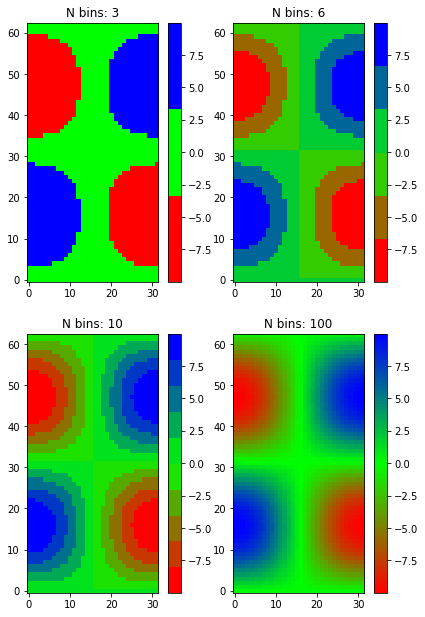

In [19]:
# For plotting see http://xarray.pydata.org/en/stable/plotting.html

from matplotlib.colors import LinearSegmentedColormap


x = np.arange(0, np.pi, 0.1)       # 0., 0.1, 0.2, ..., 3.1
y = np.arange(0, 2*np.pi, 0.1)     # 0., 0.1, 0.2, .............., 6.2
X, Y = np.meshgrid(x, y)           # X and Y as a tuple form a numpy meshgrid
Z = np.cos(X) * np.sin(Y) * 10     # Z is defined as the product of cosine and sine over this grid; so Z is a scalar field
                                   #   It is also multiplied by 10 so it will have a range of -10 to 10 a prior
    
colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
                                            # A list of three tuples defining points in color space
    
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
                          # A list of 4 elements that will correspond to the 4 plots that are pending below
                          #   indicating discretization. So the handwriting on the wall is that LinearSegmentColormap
                          #   will be doing some interpolation on our behalf

cmap_name = 'my_list'

fig, axs = plt.subplots(2, 2, figsize=(6, 9))                                    # establishes 2 x 2 matrix of sub-plots
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)   #   with some interstices

for n_bin, ax in zip(n_bins, axs.ravel()):             # note the use of both zip and .ravel() methods...
                                                       #   clearly this iterates over the sub-plots with assignment
                                                       #   of individual discretization values and axes
                                                       #
                                                       # The zip() function returns a zip object, which is an 
                                                       # iterator of tuples where the first item in each passed 
                                                       # iterator is paired together, and then the second item 
                                                       # in each passed iterator are paired together etc.
                                                       #
                                                       # numpy.ravel(array, order = ‘C’) : returns contiguous 
                                                       # flattened array(1D array with all the input-array elements 
                                                       # and with the same type as it). A copy is made only if needed.
    
    # Create the colormap
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)   # cmap_name is a string attribute (not functional)
                                                                         # colors is fixed: Our 3 stakes in the ground
                                                                         #   N = 3 is no linear interpolation
                                                                         #   N = 6 suggests trying 5... of interest
                                                                         #   N = 10 and 100 follow intuitively
    
    # Fewer bins will result in "coarser" colomap interpolation
    im = ax.imshow(Z, interpolation='nearest', origin='lower', cmap=cm)     # ax.imshow displays the Z scalar field
    ax.set_title("N bins: %s" % n_bin)                                      #   with a nice title
    fig.colorbar(im, ax=ax)                                                 #   and the helpful color bars


## S6. remarks on pyplot and DataArray native plotting

### with print(object.__doc__) to show a helpful docstring

Types and features

* raster images
* scatter plots
* line plots
* histograms
* velocity vector fields (supported on ipyleaflet as well)
* titles, annotations, overlays


The idea is to take advantage of plotting capabilities built into xarray DataArrays and
to integrate that with the matplotlib subplots that give us multiple plots for comparative 
viewing. For example a GOLIVE NetCDF file yields a vv_masked DataArray: Glacier speed 
across a UTM grid. This object has a .plot() method and even sub-plot methods:

In [20]:
# dirobj(m[0].vv_masked) produces a long list of methods including 'plot'.
# To examine .plot: 
g.dirnou(m[0].vv_masked.plot)

['contour', 'contourf', 'hist', 'imshow', 'line', 'pcolormesh']

In [21]:
print('for .plot()...')
print(m[0].vv_masked.plot.__doc__)
print('\n\nfor .plot.contour()...')
print(m[0].vv_masked.plot.contour.__doc__)
print('\n\nfor .plot.contourf()...')
print(m[0].vv_masked.plot.contourf.__doc__)
print('\n\nfor .plot.hist()...')
print(m[0].vv_masked.plot.hist.__doc__)
print('\n\nfor .plot.imshow()...')
print(m[0].vv_masked.plot.imshow.__doc__)
print('\n\nfor .plot.line()...')
print(m[0].vv_masked.plot.line.__doc__)
print('\n\nfor .plot.pcolormesh()...')
print(m[0].vv_masked.plot.pcolormesh.__doc__)

for .plot()...

    Enables use of xarray.plot functions as attributes on a DataArray.
    For example, DataArray.plot.imshow
    


for .plot.contour()...

    Contour plot of 2d DataArray

    Wraps :func:`matplotlib:matplotlib.pyplot.contour`
    

    Parameters
    ----------
    darray : DataArray
        Must be 2 dimensional, unless creating faceted plots
    x : string, optional
        Coordinate for x axis. If None use darray.dims[1]
    y : string, optional
        Coordinate for y axis. If None use darray.dims[0]
    figsize : tuple, optional
        A tuple (width, height) of the figure in inches.
        Mutually exclusive with ``size`` and ``ax``.
    aspect : scalar, optional
        Aspect ratio of plot, so that ``aspect * size`` gives the width in
        inches. Only used if a ``size`` is provided.
    size : scalar, optional
        If provided, create a new figure for the plot with the given size.
        Height (in inches) of each plot. See also: ``aspect``.
    

## S7. Showing vector fields


It would be pleasant to display localized vector fields using pyplot's plt.quiver() method. This is not yet 
working here.

In [22]:
# Does not work... also interesting thought: Does a .velocity() method exist?
# X, Y = np.meshgrid(m[2]['y'], m[2]['x'])
# U = m[2]['vy_masked']
# V = m[2]['vx_masked']
# 
# a = plt.quiver(Y, X, V, U)         # what does 'units' keyword do here if added?
# plt.xlim(535000,540000)
# plt.ylim(6675000,6680000)
# plt.title('ice velocities')
# print('velocity vector field')
# ax = a.axes
# plt.xlim(535000,540000)
# plt.ylim(6675000,6680000)
# , figsize=(20,20)

## David Shean's golive_proc.py program

In [23]:
# This code is golive_proc.py from https://github.com/dshean/vmap/tree/master/vmap
# It includes this line at the top: #! /usr/bin/env python

if False:    # So the cell runs without doing anything

    # Next section (9 lines) commented out as in the source: Just indicates preparation steps
    
    # Get the time-series dataset for path 46 row 27 of Landsat 8
    # wget -r ftp://sidads.colorado.edu/pub/DATASETS/nsidc0710_landsat8_golive_ice_velocity_v1/p046_r027/*nc
    # parallel 'gdal_translate NETCDF:"{}":vv_masked {.}_vv_masked.tif' ::: *nc
    # parallel './golive_rename.py {}' ::: L8*vv.tif
    # parallel './golive_rename.py {}' ::: L8*vv_masked.tif

    # These lines are running some code while providing a UTM bounding box for Mt. Rainier
    # make_stack.py -te '577880 5175800 611800 5205050' 2*vv.tif
    # make_stack.py -te '577880 5175800 611800 5205050' 2*vv_masked.tif
    # dem_mosaic --median *vv_masked.tif -o vv_masked

    in_fn = 'L8_046_027_048_2015_350_2016_033_v1_vv_masked.tif'        # golive result file path 27 row 48 (Rainier)
                                                                       #   this will be a 48-day interval
    a = in_fn.split('_')
    dt1 = timelib.doy2dt(int(a[4]), int(a[5]))                         # Get dt1, dt2, dtc for center; interval in days
    dt2 = timelib.doy2dt(int(a[6]), int(a[7]))
    dtc = timelib.center_date(dt1, dt2)
    ndays = (dt2 - dt1).days
    
    # Build up an output filename
    out_fn = '%s_%iday_%s-%s_%s' % (dtc.strftime('%Y%m%d'), ndays, dt1.strftime('%Y%m%d'), dt2.strftime('%Y%m%d'), in_fn) 
    print(out_fn)
    
    # clobber any pre-existing output file 
    if os.path.exists(out_fn): os.remove(out_fn)
        
    # set up symlink from out_fn to in_fn
    os.symlink(in_fn, out_fn)

    # b_ds will now be a GDAL dataset
    b_ds = gdal.Open(out_fn)
    
    # get 'masked array' from b_ds
    b = iolib.ds_getma(b_ds)

    # threshold for Rainier speed filter
    b_thresh = 1.5            # most likely 1.5 meters per day to ignore slow ice noise
    
    b[b > b_thresh] = np.ma.masked        # does the masking based on speed
    
    out_fn_masked = os.path.splitext(out_fn)[0]+'_filt.tif'
    iolib.writeGTiff(b,out_fn_masked,b_ds)                       # write an additional output file reflecting the speed filter

### lgo_mask

- 0 is moving ice
- 1 is non-moving land
- 2 is ocean

In [1]:
%%time

# prints time used when the cell is done running
# use the timer to ingest this time into a program...

start_time = timeit.default_timer()

# Here we average time series mask values (0 for ice, 1 for land) across time-series using values.mean()
if True:
    for j in range(401,403):
        for i in range(701,703):
            print(lgo.isel(y=j,x=i).data.mean())

# ...as here the time interval comes programmatically off the timer
print('\n', timeit.default_timer() - start_time, '\n\ncompare with...\n')

NameError: name 'timeit' is not defined

In [ ]:
%%time

if True:
    # Operating on a single pixel...
    #   choosing the mid-point of the lower transect, closest to Malaspina
    xMid = utm0[0][0] + (number_of_postings[0]/2.)*relative_postings[0][0]    # These must start at utm0 and add a certain 
    yMid = utm0[0][1] + (number_of_postings[0]/2.)*relative_postings[0][1]    #   number of the relative_postings vectors
    print('UTM of point of interest is', xMid, yMid, 'as easting - northing\n')
    s = vv.sel(x=xMid,y=yMid,method='nearest')           # selects a time series at one location (xMid, yMid)
    ss = s.where(s.data >= 0.)                           # substitutes nan for -9999. no data value
    # each of the following does something relevant: 
    #   print(s.values)                           # prints speeds as an ndarray (not a list; no commas!)
    #   print(s)                                  # describes DataArray (since it was derived from m['vv_masked'])        
    #   s.plot()                                  # uses .plot() native to DataArray to show a plot (-9999 to 30 m/d)
    #   print(ss.values)                          # shows the nan value substitution in ss
    #   print(ss.mean(skipna=True).values)        # use DataArray .mean() to ignore nans and print a mean of 4.127929 (sd 1.0109311)
    #   print(np.std([1., 2., 3.]))               # sidebar numpy operating on a list
    #   print(s.x, '\n')
    #   print(s, '\n')
    #   print(s.masking_info, '\n')
    #   print(s['time'])
    #   dirobj(s)
    #   dirobj(s.x)
    #   print(ss.std(), ss.mean(), ss.std()/ss.mean())
    #   print(ss.data)                                    # prints all 255 values
    print(ss.mean().data)                                 # about 1                    
    print(ss.std().data)                                  # about 4
    print(ss.std().data/ss.mean().data) 
    # print(dirobj(ss))
    print(ss.count('time').data)                          # 78 values (i.e. not nan)
    print(ss.sum().data)                                  # sum of all 78 values